The general aim is to develop a linear mixed-effects model for “diameter” as a function of “age” and “sexe”. With mixed-effects models the correlations between repeated diameter-measures of the same patients are taken into account.

 In summary; make a reasoned decision on the appropriate mixed-effects regression model, list the assumptions involved in that regression model and check whether the assumptions fit to the data. Make (at least) two figures showing the expected aorta diameter of new patients with ages varying between 20 and 50 years, and showing the expected aorta diameter of the existing patients one year after their last measurement.

In [17]:
# Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
import patsy
from scipy import stats

In [2]:
# Importing the dataset
df = pd.read_csv('marfan.csv')
df.head(10)

,Unnamed: 0,patnr,metingnr,age,sexe,diameter
0,1,1,1,20.50,0,35
1,2,1,2,21.76,0,36
2,3,1,3,21.99,0,35
3,4,1,4,22.06,0,35
4,5,1,5,22.15,0,35
5,6,1,6,24.10,0,38
6,7,1,7,26.13,0,39
7,8,2,1,32.47,0,38
8,9,2,2,34.19,0,40
9,10,2,3,34.49,0,40


In [355]:
print('Number of rows: ', len(df)) # Checking number of rows
print('Number of unique patients: ',len(set(df['patnr']))) # Checking the number of unique patients
print('\nNumber of missing values in each column: \n',df.isnull().sum()) # Checking the number of missing values in each column
negatives = df.lt(0).sum()
print("\nNumber of negative values: \n", negatives)

Number of rows:  1036
Number of unique patients:  159

Number of missing values in each column: 
 Unnamed: 0    0
patnr         0
metingnr      0
age           0
sexe          0
diameter      0
dtype: int64

Number of negative values: 
 Unnamed: 0    0
patnr         0
metingnr      0
age           0
sexe          0
diameter      0
dtype: int64


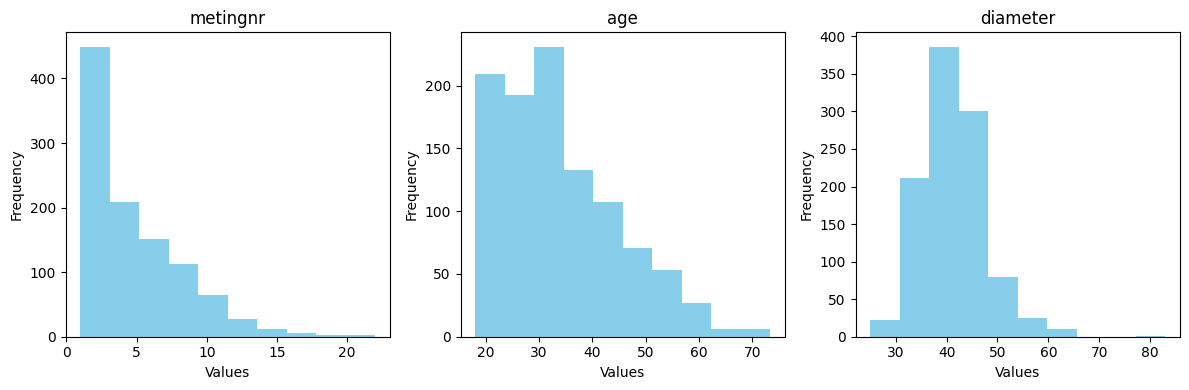

In [3]:
# Checking distributions of the data for each column
histcols = ['metingnr','age','diameter']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, column in enumerate(histcols):
    axes[i].hist(df[column], bins=10, color='skyblue')
    axes[i].set_title(column)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [4]:
# Adding a column in the dataframe for follow-up time
df['follow_up'] = float('nan')
for i in range(1, 160):
    f = max(df.loc[df['patnr'] == i, 'age']) - min(df.loc[df['patnr'] == i, 'age'])
    df.loc[df['patnr'] == i, 'follow_up'] = f
df.head(10)

,Unnamed: 0,patnr,metingnr,age,sexe,diameter,follow_up
0,1,1,1,20.50,0,35,5.63
1,2,1,2,21.76,0,36,5.63
2,3,1,3,21.99,0,35,5.63
3,4,1,4,22.06,0,35,5.63
4,5,1,5,22.15,0,35,5.63
5,6,1,6,24.10,0,38,5.63
6,7,1,7,26.13,0,39,5.63
7,8,2,1,32.47,0,38,22.01
8,9,2,2,34.19,0,40,22.01
9,10,2,3,34.49,0,40,22.01


###### 1. Start by giving a data description. 

In [5]:
# Table 1 - General Characteristics
cols = ['age','diameter']
values = []
for i in cols:
    median = round(df[i].median(),2)
    q1 = round(df[i].quantile(0.25),1)
    q3 = round(df[i].quantile(0.75),1)
    value = str(median) + ' (' + str(q1) + ' - ' + str(q3) + ')'
    values.append(value)
    
tb1 = pd.DataFrame(values, columns = ['Median (Q1 - Q3)'])
tb1.index = ['Age','Diameter']

sex = [0,1]; total = []
for i in sex:
    nr = df['sexe'].value_counts().get(i) 
    prct = round(((nr / len(df)) * 100),1)
    value = str(nr) + ' ('+ str(prct) + ' %)' 
    total.append(value)
tb1_sex = pd.DataFrame(total, columns = ['n (%)'])
tb1_sex.index = ['Female','Male']
tb1

,Median (Q1 - Q3)
Age,31.56 (25.2 - 40.6)
Diameter,41.0 (37.0 - 45.0)


In [359]:
tb1_sex

,n (%)
Female,776 (74.9 %)
Male,260 (25.1 %)


In [6]:
# Table 2 : General Characteristics grouped by patnr
# Grouping the data by unique patient numbers
group_patnr = df.groupby('patnr').agg({'age': ['min', 'mean','max'], 
                                        'diameter': ['min','mean','max'],
                                       'follow_up':'mean',
                                       'metingnr':'count'
                                       }).round(2)

new_cols = {'age': 'Age', 'diameter': 'Diameter','follow_up':'Follow up',
            'metingnr': 'Meeting number','count':'Number of msts','min':'Min','mean':'Mean','max':'Max'}
group_patnr.rename(columns=new_cols, inplace=True)
group_patnr.head()

Age               Diameter            Follow up Meeting number
         Min   Mean    Max      Min   Mean Max      Mean Number of msts
patnr                                                                  
1      20.50  22.67  26.13       35  36.14  39      5.63              7
2      32.47  38.43  54.48       30  36.30  40     22.01             10
3      27.33  31.32  34.41       31  34.56  38      7.08              9
4      18.58  22.85  27.08       30  31.33  32      8.50              3
5      26.89  31.45  39.87       34  39.29  42     12.98             17

In [7]:
tb2 = pd.DataFrame({'Median':round(group_patnr.median(),2),
                  'Q1' : round(group_patnr.quantile(0.25),1),
                 'Q3' : round(group_patnr.quantile(0.75),1)})
tb2

Median    Q1    Q3
Age            Min              26.47  19.2  34.7
               Mean             30.26  22.5  37.3
               Max              32.96  24.8  41.9
Diameter       Min              39.00  34.0  44.0
               Mean             41.17  36.4  46.2
               Max              43.00  39.0  49.0
Follow up      Mean              5.80   3.0   8.5
Meeting number Number of msts    6.00   3.0   9.0

In [8]:
sex = [0,1]; total = []
for i in sex:
    nr = group_patnr['Sex'].value_counts().get(i) 
    prct = round(((nr / len(group_patnr)) * 100),1)
    value = str(nr) + ' ('+ str(prct) + ' %)' 
    total.append(value)
tb2_sex = pd.DataFrame(total, columns = ['n (%)'])
tb2_sex.index = ['Female','Male']
tb2_sex

KeyError: 'Sex'

In [9]:
# Table 3 - General statistics by meeting number (metingnr)
group_metingnr = df.groupby('metingnr').agg({'age': ['mean','std'], 
                                        'diameter': ['mean','std']}).round(2)
new_cols = {'age': 'Age', 'diameter': 'Diameter'}
group_metingnr.rename(columns=new_cols, inplace=True)
group_metingnr.head()

Age        Diameter      
           mean    std     mean   std
metingnr                             
1         28.73  10.81    40.54  7.65
2         30.61  10.77    41.27  7.00
3         31.94  10.98    41.26  6.24
4         33.46  10.90    40.67  6.13
5         33.88  10.35    41.43  6.61

In [10]:
fem = []; male = []; total = []
for i in range(1,23):
    n = df[df['metingnr']==i]['patnr'].count()
    n_prct = round(((n / len(group_patnr)) * 100))
    n_val = str(n) + ' ('+ str(n_prct) + ' %)'
    total.append(n_val)
    for j in range(0,2):
        s = df[(df['metingnr']==i) & (df['sexe']==j)]['patnr'].count()
        s_prct = round(((s / len(group_patnr)) * 100))
        s_val = str(s) + ' ('+ str(s_prct) + ' %)'
        if j == 0: 
            fem.append(s_val)
        else :
            male.append(s_val)
    
meet2 = pd.DataFrame({'No. of pts': total, 'Females (%)': fem, 'Males (%)': male})
meet2.index = range(1,23)
meet2

,No. of pts,Females (%),Males (%)
1,159 (100 %),108 (68 %),51 (32 %)
2,153 (96 %),106 (67 %),47 (30 %)
3,137 (86 %),99 (62 %),38 (24 %)
4,111 (70 %),83 (52 %),28 (18 %)
5,98 (62 %),74 (47 %),24 (15 %)
6,83 (52 %),66 (42 %),17 (11 %)
7,69 (43 %),54 (34 %),15 (9 %)
8,61 (38 %),49 (31 %),12 (8 %)
9,51 (32 %),42 (26 %),9 (6 %)
10,39 (25 %),32 (20 %),7 (4 %)


In [11]:
tb3 = pd.concat([group_metingnr, meet2],axis=1)
tb3 = tb3.rename_axis('Meeting num')
tb3

,"(Age, mean)","(Age, std)","(Diameter, mean)","(Diameter, std)",No. of pts,Females (%),Males (%)
Meeting num,,,,,,,
1,28.73,10.81,40.54,7.65,159 (100 %),108 (68 %),51 (32 %)
2,30.61,10.77,41.27,7.00,153 (96 %),106 (67 %),47 (30 %)
3,31.94,10.98,41.26,6.24,137 (86 %),99 (62 %),38 (24 %)
4,33.46,10.90,40.67,6.13,111 (70 %),83 (52 %),28 (18 %)
5,33.88,10.35,41.43,6.61,98 (62 %),74 (47 %),24 (15 %)
6,35.72,10.60,41.63,5.72,83 (52 %),66 (42 %),17 (11 %)
7,37.19,11.03,41.58,5.88,69 (43 %),54 (34 %),15 (9 %)
8,38.21,10.78,41.75,5.03,61 (38 %),49 (31 %),12 (8 %)
9,38.51,9.61,41.82,4.97,51 (32 %),42 (26 %),9 (6 %)


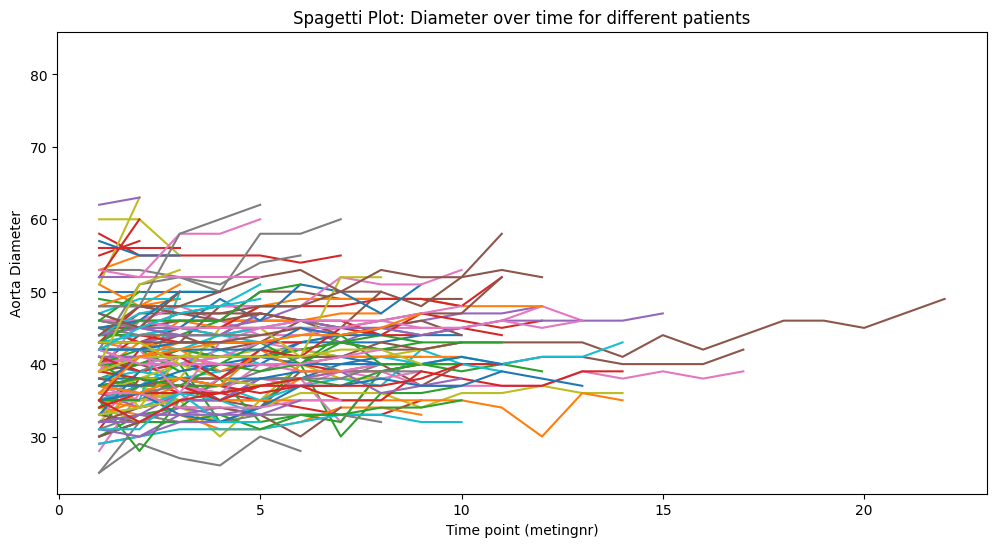

In [12]:
## Visualization plots to see aorta measures
# Creating a spaghetti plot with different colors for each patient
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(df['patnr'])):
    x = df[df['patnr']==i]['metingnr']
    y_value = df[df['patnr']==i]['diameter']
    ax.plot(x, y_value, label=f'Line{i}')

ax.set_xlabel('Time point (metingnr)')
ax.set_ylabel('Aorta Diameter')
ax.set_title('Spagetti Plot: Diameter over time for different patients')
plt.show()

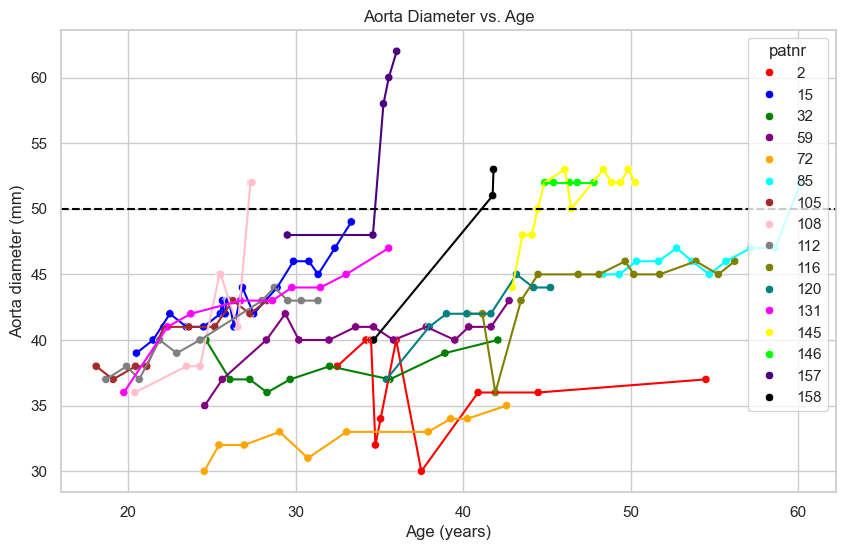

In [13]:
# Diameter with age in a few clinically significant patients (considered in subsets of 16)
plot_data = df[df['patnr'].isin([2, 15, 32, 59, 72, 85, 105, 108, 112, 116, 120, 131, 145, 146, 157, 158])]
# Giving different colours for different patients to make it more noticeable
patient_palette = {2: "red", 15: "blue", 32: "green", 59: "purple", 
                   72: "orange", 85: "cyan", 105: "brown", 108: "pink",
                   112: "gray", 116: "olive", 120: "teal", 131: "magenta",
                   145: "yellow", 146: "lime", 157: "indigo", 158: "black"}
sns.set(style="whitegrid")  # Setting seaborn style
plt.figure(figsize=(10, 6))
# Scatter plot
sns.scatterplot(x='age', y='diameter', hue='patnr', 
                data=plot_data, palette=patient_palette)
# Line plot
sns.lineplot(x='age', y='diameter', hue='patnr', data=plot_data, palette=patient_palette,legend = False)
plt.axhline(y=50, color='black', linestyle='--', label='Reference Line at y=50mm')
# Adding labels
plt.xlabel("Age (years)")
plt.ylabel("Aorta diameter (mm)")
plt.title("Aorta Diameter vs. Age")
plt.show()

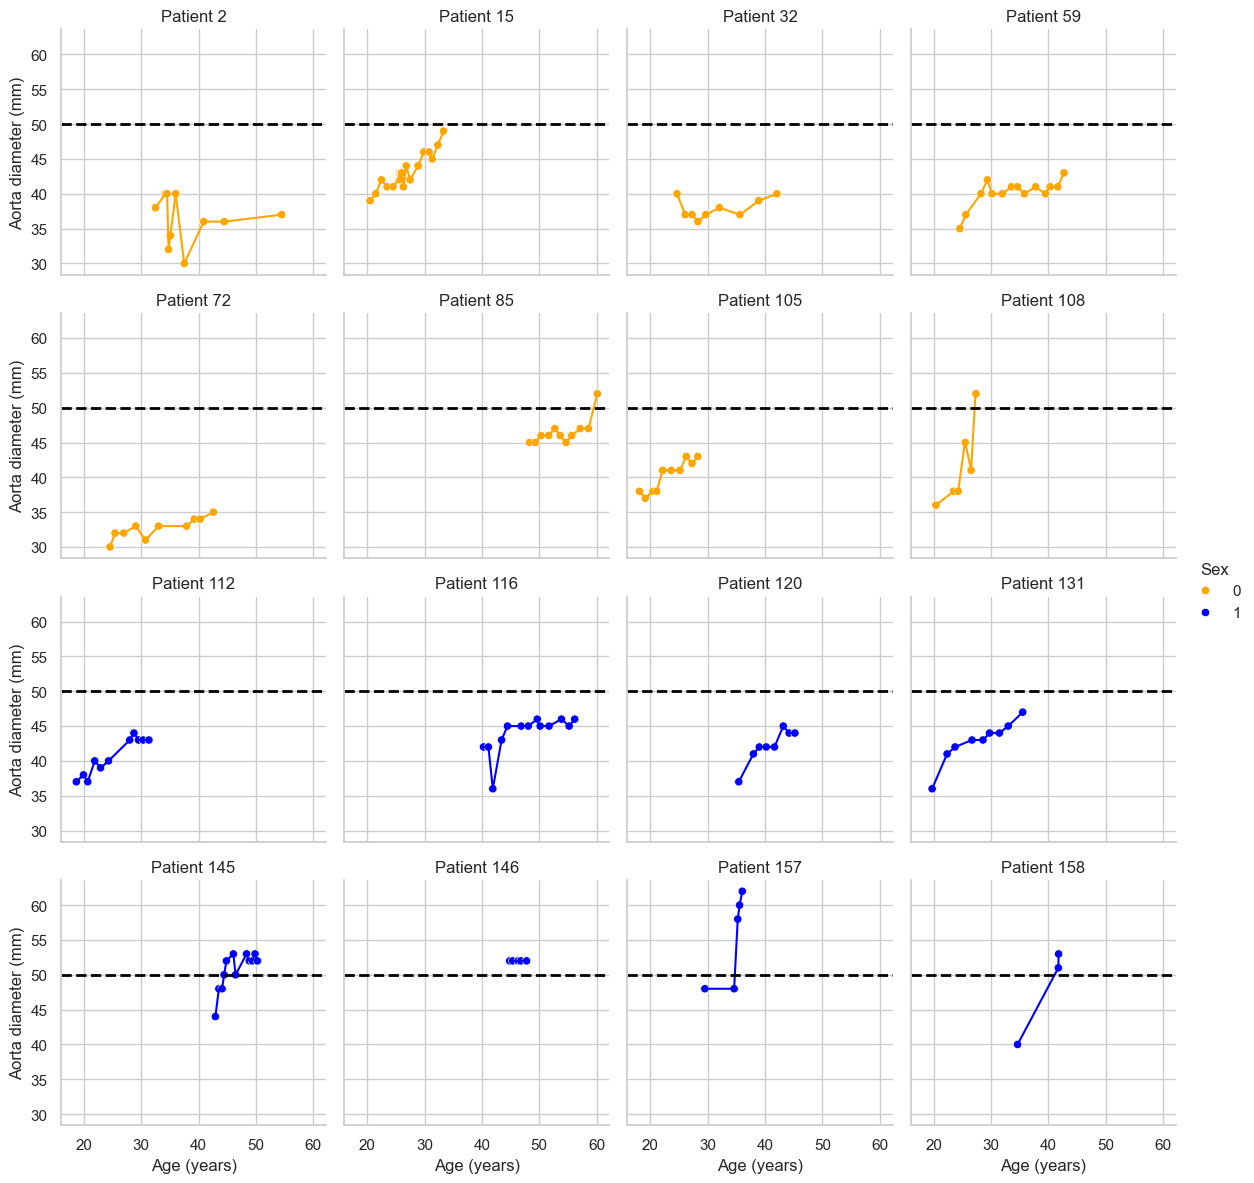

In [14]:
# Plotting a line plot to check the aorta diameter growth over time individually for each patient
patients = [2, 15, 32, 59, 72, 85, 105, 108, 112, 116, 120, 131, 145, 146, 157, 158]
# Create a FacetGrid for each patient
g = sns.FacetGrid(df[df['patnr'].isin(patients)], col="patnr", col_wrap=4, height=3, legend_out=True)
g.map(sns.lineplot, 'age', 'diameter', hue='sexe',palette={1: 'blue', 0: 'orange'},data=df[df['patnr'].isin(patients)])
g.map(sns.scatterplot, 'age', 'diameter',hue='sexe',palette={1: 'blue', 0: 'orange'}, data=df[df['patnr'].isin(patients)])
g.map(lambda **kwargs: plt.axhline(y=50, color='black', linestyle='--', linewidth=2))
g.add_legend(title='Sex')
g.set_axis_labels("Age (years)", "Aorta diameter (mm)")
g.set_titles("Patient {col_name}")

plt.show()

The above 3 plots show show trends within the data. However, different patients have different starting measurements in their aorta diameter. Also the rate of increases are different. Therefore, we decide to use a linear mixed-effects regression model. 

###### 2. Next, fit an appropriated linear mixed-effects regression model and check the assumptions. 

Before using the linear mixed-effects model, several assumptions (data normality, data linearity and random effect normality) have to be checked. We will test 3 different models and select the best one based on their AIC and BIC scores. 

Model 1: Random intercept - constant slope model

In [15]:
# Model 1 : Random intercept and fixed slope
formula1 = 'diameter ~ age + sexe'
groups1 = 'patnr'
re_formula1 = '1'

model1 = smf.mixedlm(formula1, re_formula = re_formula1, groups = groups1, data=df)
result1 = model1.fit(reml=False,method='powell')
print(result1.summary())
print('AIC : ', result1.aic)
print('BIC : ', result1.bic)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: diameter  
No. Observations: 1036    Method:             ML        
No. Groups:       159     Scale:              3.7673    
Min. group size:  1       Log-Likelihood:     -2489.1532
Max. group size:  22      Converged:          Yes       
Mean group size:  6.5                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     29.402    0.899 32.695 0.000 27.640 31.165
age            0.311    0.019 16.628 0.000  0.274  0.347
sexe           8.392    1.159  7.242 0.000  6.121 10.664
patnr Var     45.305    3.002                           

AIC :  4988.306464698292
BIC :  5013.022076812389


C:\Users\Nancy\AppData\Local\Temp\ipykernel_6784\4156572512.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axes[1,1] = sns.distplot(result1.resid,hist =False, kde_kws = {"shade" : True, "lw": 1},fit = stats.norm)
C:\Users\Nancy\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


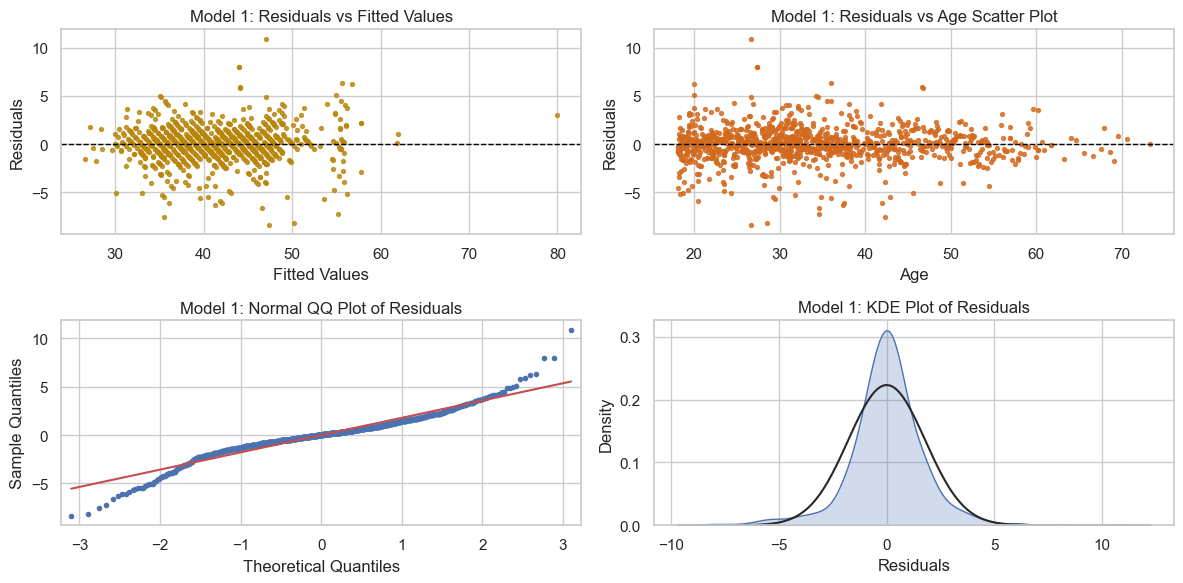

In [18]:
# Assumptions Testing for model 1 : Residuals
independent_variable = result1.model.exog[:, result1.model.exog_names.index('age')]
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,6))

axes[0,0].scatter(result1.fittedvalues, result1.resid, color = 'darkgoldenrod',alpha=0.8, s= 8)
axes[0,0].axhline(y=0, color='black', linestyle='--', linewidth=1) 
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Model 1: Residuals vs Fitted Values')

axes[0,1].scatter(independent_variable, result1.resid, alpha=0.8,color='chocolate', s=8)
axes[0,1].axhline(y=0, color='black', linestyle='--', linewidth=1) 
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Model 1: Residuals vs Age Scatter Plot')

sm.qqplot(result1.resid, markersize=3 ,line='s',ax=axes[1,0])
axes[1,0].set_title('Model 1: Normal QQ Plot of Residuals')

axes[1,1] = sns.distplot(result1.resid,hist =False, kde_kws = {"shade" : True, "lw": 1},fit = stats.norm)
axes[1,1].set_title("Model 1: KDE Plot of Residuals")
axes[1,1].set_xlabel("Residuals")

plt.tight_layout()
plt.show()

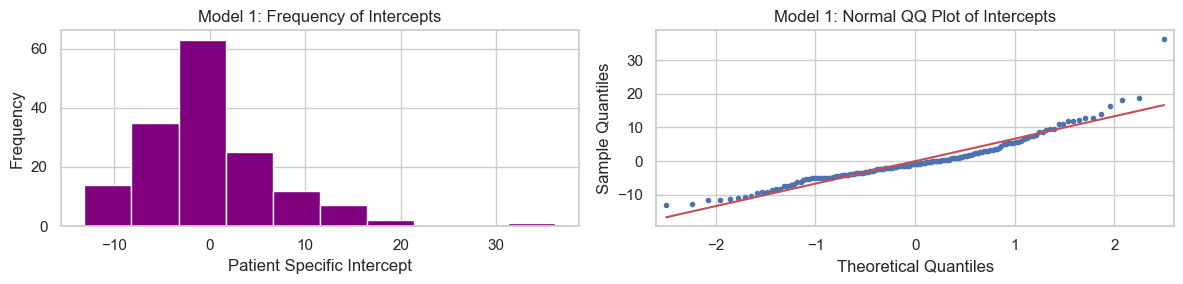

In [19]:
# Assumptions for the Random Effects (Random Intercept)
all_random_effects = np.concatenate(list(result1.random_effects.values()))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
axes[0].hist(all_random_effects,color = 'purple',bins=10)
axes[0].set_xlabel("Patient Specific Intercept")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Model 1: Frequency of Intercepts")

sm.qqplot(all_random_effects, markersize=3, line='s',ax= axes[1])
axes[1].set_title('Model 1: Normal QQ Plot of Intercepts')

plt.tight_layout()
plt.show()

In [20]:
# Model 2 : Random slope and constant intercept
formula2 = 'diameter ~ age + sexe'
groups2 = 'patnr'
re_formula2 = '0 + age' 

model2 = smf.mixedlm(formula2, re_formula =re_formula2, groups = groups2, data=df)
result2 = model2.fit(reml=False, method = 'powell')
print(result2.summary())
print("AIC : ",result2.aic)
print("BIC : ",result2.bic)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: diameter  
No. Observations: 1036    Method:             ML        
No. Groups:       159     Scale:              3.5331    
Min. group size:  1       Log-Likelihood:     -2496.9431
Max. group size:  22      Converged:          Yes       
Mean group size:  6.5                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     27.749    0.652 42.590 0.000 26.472 29.026
age            0.423    0.031 13.740 0.000  0.363  0.484
sexe           5.735    1.013  5.662 0.000  3.750  7.721
age Var        0.078    0.006                           

AIC :  5003.88629773193
BIC :  5028.601909846027


C:\Users\Nancy\AppData\Local\Temp\ipykernel_6784\2753008853.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axes[1,1] = sns.distplot(result2.resid,hist =False, kde_kws = {"shade" : True, "lw": 1},fit = stats.norm)
C:\Users\Nancy\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


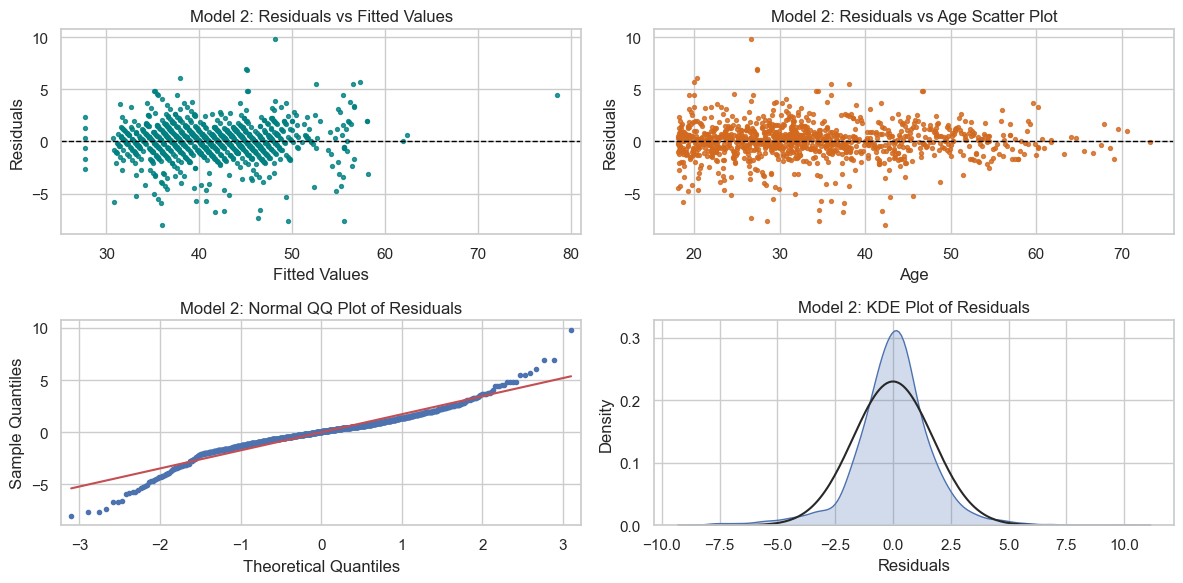

In [21]:
# Assumptions testing for Model 2: Residuals
independent_variable = result2.model.exog[:, result2.model.exog_names.index('age')]
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,6))

axes[0,0].scatter(result2.fittedvalues, result2.resid, color = 'teal',alpha=0.8, s= 8)
axes[0,0].axhline(y=0, color='black', linestyle='--', linewidth=1) 
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Model 2: Residuals vs Fitted Values')

axes[0,1].scatter(independent_variable, result2.resid, alpha=0.8,color='chocolate', s=8)
axes[0,1].axhline(y=0, color='black', linestyle='--', linewidth=1) 
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Model 2: Residuals vs Age Scatter Plot')

sm.qqplot(result2.resid, markersize=3 ,line='s',ax=axes[1,0])
axes[1,0].set_title('Model 2: Normal QQ Plot of Residuals')

axes[1,1] = sns.distplot(result2.resid,hist =False, kde_kws = {"shade" : True, "lw": 1},fit = stats.norm)
axes[1,1].set_title("Model 2: KDE Plot of Residuals")
axes[1,1].set_xlabel("Residuals")

plt.tight_layout()
plt.show()

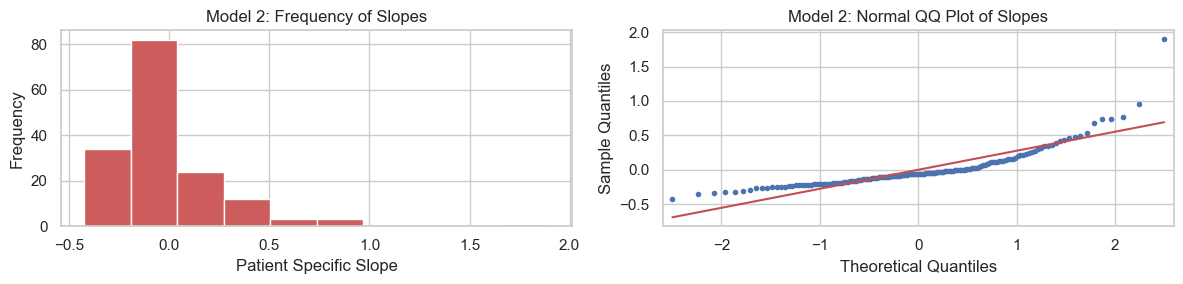

In [22]:
# Assumptions for the Random Effects (Random Slope)
all_random_effects = np.concatenate(list(result2.random_effects.values()))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
axes[0].hist(all_random_effects,color = 'indianred',bins=10)
axes[0].set_xlabel("Patient Specific Slope")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Model 2: Frequency of Slopes")

sm.qqplot(all_random_effects, markersize=3, line='s',ax= axes[1])
axes[1].set_title('Model 2: Normal QQ Plot of Slopes')

plt.tight_layout()
plt.show()

In [23]:
# Model 3: Random intercept and random slope
formula3 = 'diameter ~ age + sexe'
groups3 = 'patnr'
re_formula3 = '1 + age' 

model3 = smf.mixedlm(formula3, re_formula = re_formula3, groups=groups3, data=df)
result3 = model3.fit(reml=False,method = 'powell')
print(result3.summary())
print("AIC : ",result3.aic)
print("BIC : ",result3.bic)

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  diameter  
No. Observations:  1036     Method:              ML        
No. Groups:        159      Scale:               2.7142    
Min. group size:   1        Log-Likelihood:      -2433.7055
Max. group size:   22       Converged:           Yes       
Mean group size:   6.5                                     
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        27.217    1.323 20.567 0.000 24.623 29.810
age               0.396    0.041  9.710 0.000  0.316  0.477
sexe              8.461    1.233  6.862 0.000  6.044 10.877
patnr Var       140.909   17.879                           
patnr x age Cov  -3.569    0.543                           
age Var           0.134    0.019                           

AIC :  4881.410990807793
BIC :  4916.012847767529


C:\Users\Nancy\AppData\Local\Temp\ipykernel_6784\222172654.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  axes[1,1] = sns.distplot(result3.resid,hist =False, kde_kws = {"shade" : True, "lw": 1},fit = stats.norm)
C:\Users\Nancy\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


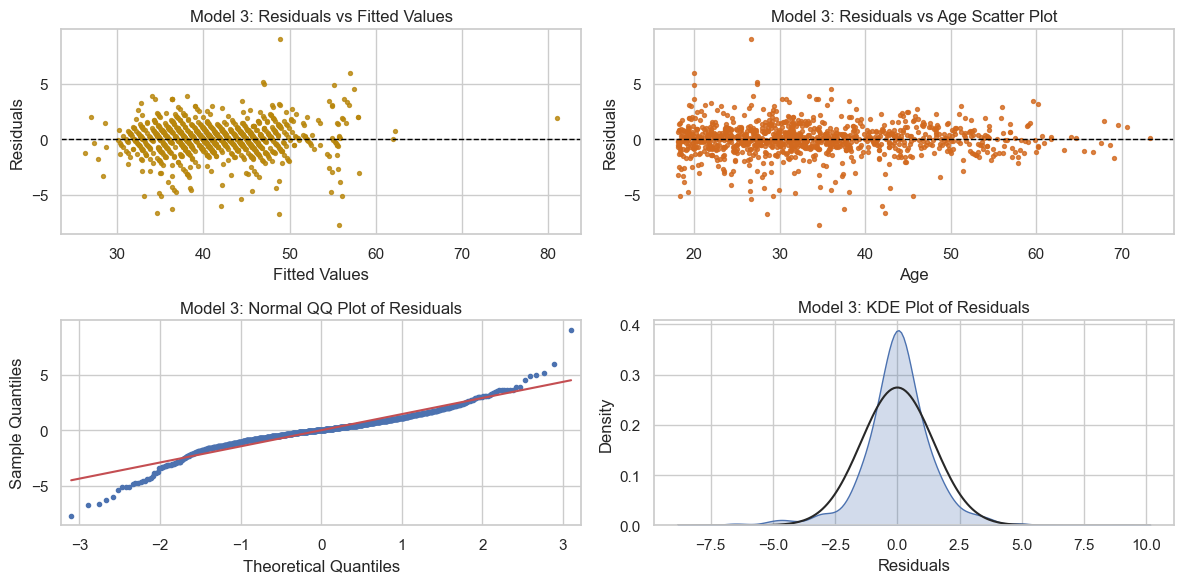

In [24]:
# Assumptions testing for Model 3: Residuals
independent_variable = result3.model.exog[:, result3.model.exog_names.index('age')]
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,6))

axes[0,0].scatter(result3.fittedvalues, result3.resid, color = 'darkgoldenrod',alpha=0.8, s= 8)
axes[0,0].axhline(y=0, color='black', linestyle='--', linewidth=1) 
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Model 3: Residuals vs Fitted Values')

axes[0,1].scatter(independent_variable, result3.resid, alpha=0.8,color='chocolate', s=8)
axes[0,1].axhline(y=0, color='black', linestyle='--', linewidth=1) 
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Model 3: Residuals vs Age Scatter Plot')

sm.qqplot(result3.resid, markersize=3 ,line='s',ax=axes[1,0])
axes[1,0].set_title('Model 3: Normal QQ Plot of Residuals')

axes[1,1] = sns.distplot(result3.resid,hist =False, kde_kws = {"shade" : True, "lw": 1},fit = stats.norm)
axes[1,1].set_title("Model 3: KDE Plot of Residuals")
axes[1,1].set_xlabel("Residuals")

plt.tight_layout()
plt.show()

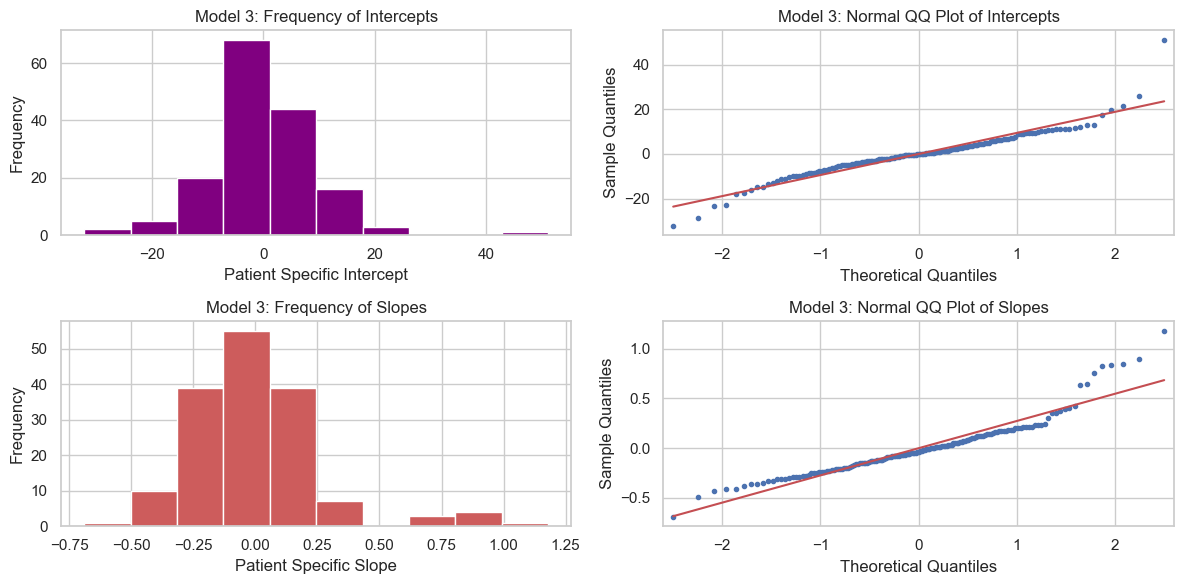

In [25]:
## Assumptions for the Random Effects (Random Intercept and Random Slope)
# Making a list of all the intercept values and slopes separately
intercepts = []; slopes = []
values = list(result3.random_effects.values())
for i in range(0,len(values)):
    intercepts.append(values[i]['patnr'])
    slopes.append(values[i]['age'])

# Creating Arrays since QQplots expects an array-like object instead of lists
intercept_array = np.array(intercepts)
slope_array = np.array(slopes)

# Plotting the plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
axes[0,0].hist(intercept_array,color = 'purple',bins=10)
axes[0,0].set_xlabel("Patient Specific Intercept")
axes[0,0].set_ylabel("Frequency")
axes[0,0].set_title("Model 3: Frequency of Intercepts")

sm.qqplot(intercept_array, markersize=3, line='s',ax= axes[0,1])
axes[0,1].set_title('Model 3: Normal QQ Plot of Intercepts')

axes[1,0].hist(slope_array,color = 'indianred',bins=10)
axes[1,0].set_xlabel("Patient Specific Slope")
axes[1,0].set_ylabel("Frequency")
axes[1,0].set_title("Model 3: Frequency of Slopes")

sm.qqplot(slope_array, markersize=3, line='s',ax= axes[1,1])
axes[1,1].set_title('Model 3: Normal QQ Plot of Slopes')

plt.tight_layout()
plt.show()

In [27]:
# Making a table for AIC and BIC values of all 3 models
aic = [round(result1.aic,3), round(result2.aic,3), round(result3.aic,3)]
bic = [round(result1.bic,3), round(result2.bic,3), round(result3.bic,3)]
model = ['Random intercept & Fixed slope',
        'Fixed intercept & Random slope',
        'Random intercept & Random slope']
values = {'Type of Model':model,'AIC':aic, 'BIC':bic}
tb4 = pd.DataFrame(values)
tb4.index = ['Model 1','Model 2','Model 3']
tb4

,Type of Model,AIC,BIC
Model 1,Random intercept & Fixed slope,4988.306,5013.022
Model 2,Fixed intercept & Random slope,5003.886,5028.602
Model 3,Random intercept & Random slope,4881.411,4916.013


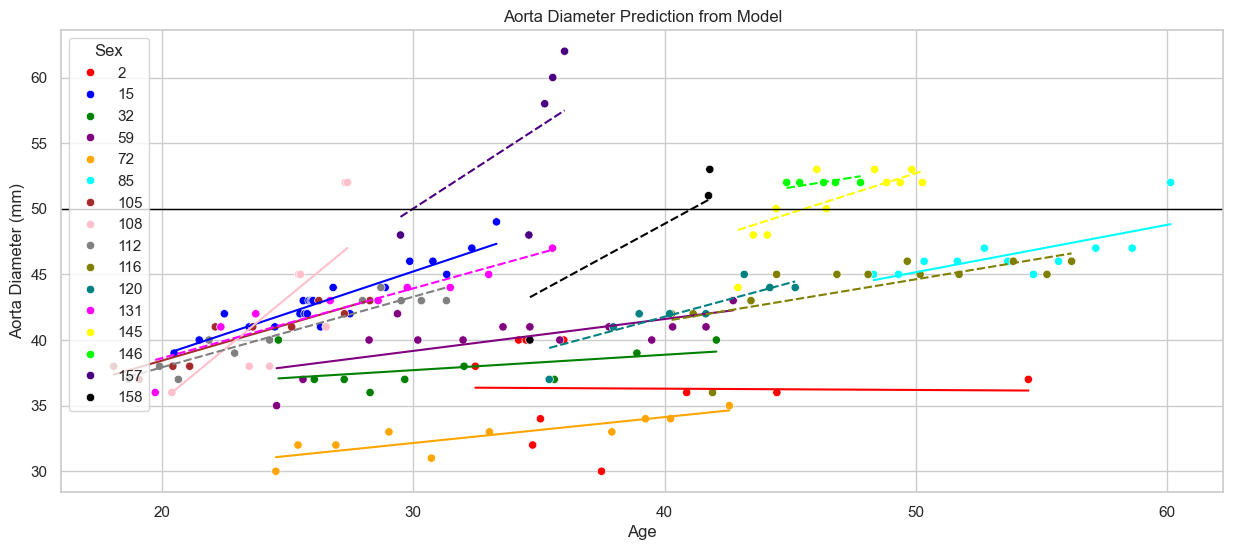

In [424]:
# Model 3 performance comparing the actual diameter and the model's predicted diameters
new_df = plot_data.copy()
new_df['predicted'] = result3.fittedvalues
plt.figure(figsize=(15, 6))

# Real diameter
sns.scatterplot(data=plot_data, x='age', y='diameter', hue='patnr',legend=True,
                markers=True, palette=patient_palette)

# Predicted values
sns.lineplot(data=new_df, x='age', y='predicted', hue='patnr', legend=False,
             style='sexe', markers=False,palette =patient_palette)
plt.axhline(y=50, color='black', linestyle='-', linewidth=1)
plt.title('Aorta Diameter Prediction from Model')
plt.xlabel('Age')
plt.ylabel('Aorta Diameter (mm)')
plt.legend(title='Sex', loc='upper left')
plt.grid(True)
plt.show()

###### 3. Make a figure showing the expected values (and confidence bands) of the aorta diameter for new male and female patients with age varying between 20 and 50 years. 

C:\Users\Nancy\AppData\Local\Temp\ipykernel_6784\645563063.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_long = pd.concat([data_long, pd.DataFrame({'x': x, 'y': y, 'curve': i,'sexe': new_data.loc[i, 'sexe']})])
C:\Users\Nancy\AppData\Local\Temp\ipykernel_6784\645563063.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for curve, group_data in data_long.groupby('curve'):


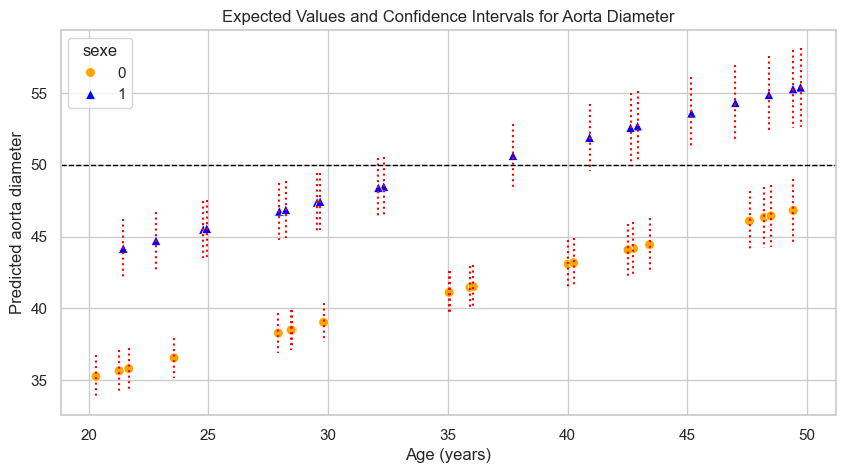

In [28]:
# Taking 40 new patients in the age range of 20 - 50
new_data = pd.DataFrame({'patnr': np.arange(1, 41),
                         'sexe': np.random.choice([0, 1], size=40, replace=True),
                         'age': np.random.uniform(20., 50., size=40)})

# Design matrix for new_data
design_matrix = patsy.dmatrix('age + sexe', data=new_data, return_type='dataframe')

# Get predicted values and standard errors
pred_var = np.diag(np.dot(np.dot(design_matrix, result3.cov_params().iloc[:3, :3]), design_matrix.T))
new_data['SE'] = np.sqrt(pred_var)
new_data['mean'] = result3.predict(exog=new_data)

# Create a dataframe to plot CI
data_long = pd.DataFrame(columns=['x', 'y', 'curve'])
for i in range(len(new_data)):
    y = [new_data.loc[i, 'mean'] + 1.96 * new_data.loc[i, 'SE'], new_data.loc[i, 'mean'] - 1.96 * new_data.loc[i, 'SE']]
    x = [new_data.loc[i, 'age'], new_data.loc[i, 'age']]
    data_long = pd.concat([data_long, pd.DataFrame({'x': x, 'y': y, 'curve': i,'sexe': new_data.loc[i, 'sexe']})])

data_long['curve'] = pd.Categorical(data_long['curve'])
# Create plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
for curve, group_data in data_long.groupby('curve'):
    plt.plot(group_data['x'], group_data['y'], color='red', linestyle='dotted')

# Create scatter plot for newdata
scatter_plot = sns.scatterplot(x='age', y='mean', hue='sexe', style='sexe', data=new_data, palette={0: 'orange', 1: 'blue'}, markers=['o', '^'], s=50)

# Set labels and title
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)
plt.xlabel("Age (years)")
plt.ylabel("Predicted aorta diameter")
plt.title("Expected Values and Confidence Intervals for Aorta Diameter")

# Show the plot
plt.show()

In [38]:
result3.fe_params

Intercept    27.216599
age           0.396495
sexe          8.460664
dtype: float64

###### 4. Make a figure showing the expected values (and confidence bands) of the current patients but one year later than their ages at the last measurement and given the available aorta measurements. 

In [59]:
# Creating newdata
new_data = df[['age', 'patnr', 'metingnr', 'diameter','sexe']].copy()
predictionsdata = pd.DataFrame(columns=['age', 'patnr','metingnr','sexe'])
#Add new measurements
for pat in new_data['patnr'].unique():
    age_max = new_data.loc[new_data['patnr'] == pat, 'age'].max()
    metingnr_max = new_data.loc[new_data['patnr'] == pat, 'metingnr'].max()
    
    row = pd.DataFrame([{'age':age_max + 1,'patnr':pat,'metingnr':metingnr_max + 1,
           'sexe':new_data.loc[new_data['patnr'] == pat, 'sexe'].iloc[0]}])
    predictionsdata = pd.concat([predictionsdata, row],ignore_index=True)
#new_data['prediction'] = result3.predict(exog=new_data)
predictionsdata.head()

C:\Users\Nancy\AppData\Local\Temp\ipykernel_6784\3047941883.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictionsdata = pd.concat([predictionsdata, row],ignore_index=True)


,age,patnr,metingnr,sexe
0,27.13,1,8,0
1,55.48,2,11,0
2,35.41,3,10,0
3,28.08,4,4,0
4,40.87,5,18,0


In [95]:
predictionsdata ['prediction'] = result3.predict(exog = predictionsdata)
predictionsdata.head()

AttributeError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
'DataFrame' object has no attribute 'dtype'

In [78]:
re = result3.random_effects
# Multiply each BLUP by the random effects design matrix for one group
rex = [np.dot(model3.exog_re_li[j], re[k]) for (j, k) in enumerate(model3.group_labels)]
# Add the fixed and random terms to get the overall prediction
#rex = np.concatenate(rex)
rex

[array([-0.53792431, -0.26563101, -0.21592668, -0.20079928, -0.18134976,
         0.24005654,  0.67875129]),
 array([ -3.72398959,  -4.42293054,  -4.54483885,  -4.65049271,
         -4.77646463,  -5.15438038,  -5.76392191,  -7.14148577,
         -8.60032183, -12.66799565]),
 array([-4.22477642, -4.84035415, -4.85900802, -4.89217045, -4.93569615,
        -5.19063238, -5.341936  , -5.48287636, -5.69221424]),
 array([-4.49112117, -4.84469475, -5.18842405]),
 array([ 0.20056341,  0.13033939,  0.08872515,  0.06141581,  0.04190914,
         0.03020514,  0.01329935, -0.11804557, -0.25329183, -0.37813453,
        -0.50817901, -0.59660926, -0.76436664, -0.90221379, -1.01145115,
        -1.2130201 , -1.48741396]),
 array([-2.19065263, -2.27405117, -2.29047816, -2.30943237, -2.32712297,
        -2.37008585, -2.47749307, -2.60385449, -2.64176292, -2.68978026,
        -2.8439412 , -2.94376673, -3.06633731, -3.21544379, -3.40372232,
        -3.51997483, -3.54145627]),
 array([-11.68261789, -11.71109

In [92]:
model3.exog_re_li

[array([[ 1.  , 20.5 ],
        [ 1.  , 21.76],
        [ 1.  , 21.99],
        [ 1.  , 22.06],
        [ 1.  , 22.15],
        [ 1.  , 24.1 ],
        [ 1.  , 26.13]]),
 array([[ 1.  , 32.47],
        [ 1.  , 34.19],
        [ 1.  , 34.49],
        [ 1.  , 34.75],
        [ 1.  , 35.06],
        [ 1.  , 35.99],
        [ 1.  , 37.49],
        [ 1.  , 40.88],
        [ 1.  , 44.47],
        [ 1.  , 54.48]]),
 array([[ 1.  , 27.33],
        [ 1.  , 30.3 ],
        [ 1.  , 30.39],
        [ 1.  , 30.55],
        [ 1.  , 30.76],
        [ 1.  , 31.99],
        [ 1.  , 32.72],
        [ 1.  , 33.4 ],
        [ 1.  , 34.41]]),
 array([[ 1.  , 18.58],
        [ 1.  , 22.89],
        [ 1.  , 27.08]]),
 array([[ 1.  , 26.89],
        [ 1.  , 27.43],
        [ 1.  , 27.75],
        [ 1.  , 27.96],
        [ 1.  , 28.11],
        [ 1.  , 28.2 ],
        [ 1.  , 28.33],
        [ 1.  , 29.34],
        [ 1.  , 30.38],
        [ 1.  , 31.34],
        [ 1.  , 32.34],
        [ 1.  , 33.02],
        

In [84]:
new_data.head(10)

,age,patnr,metingnr,diameter,sexe
0,20.50,1,1,35,0
1,21.76,1,2,36,0
2,21.99,1,3,35,0
3,22.06,1,4,35,0
4,22.15,1,5,35,0
5,24.10,1,6,38,0
6,26.13,1,7,39,0
7,32.47,2,1,38,0
8,34.19,2,2,40,0
9,34.49,2,3,40,0


In [ ]:
new_data['prediction'] = result3.predict(exog = new_dataFix)
#new_data['prediction'] = result3.predict(exog=new_data)
new_data.head()

In [30]:
## Calculating the Confidence Intervals
cov_matrix = result3.cov_params().iloc[1:3, 1:3]

# Calculating standard errors
se = np.sqrt(np.diag(np.dot(np.dot(new_data[['age', 'sexe']].values, 
                                   cov_matrix), new_data[['age', 'sexe']].values.T)))

# Calculating prediction intervals
new_data['lower_ci'] = new_data['prediction'] - 1.96 * se
new_data['upper_ci'] = new_data['prediction'] + 1.96 * se
new_data.head()

,age,patnr,metingnr,diameter,sexe,prediction,lower_ci,upper_ci
0,20.50,1,1,35.0,0,35.344751,33.704036,36.985466
1,21.76,1,2,36.0,0,35.844335,34.102776,37.585894
2,21.99,1,3,35.0,0,35.935529,34.175561,37.695496
3,22.06,1,4,35.0,0,35.963284,34.197714,37.728853
4,22.15,1,5,35.0,0,35.998968,34.226195,37.771741


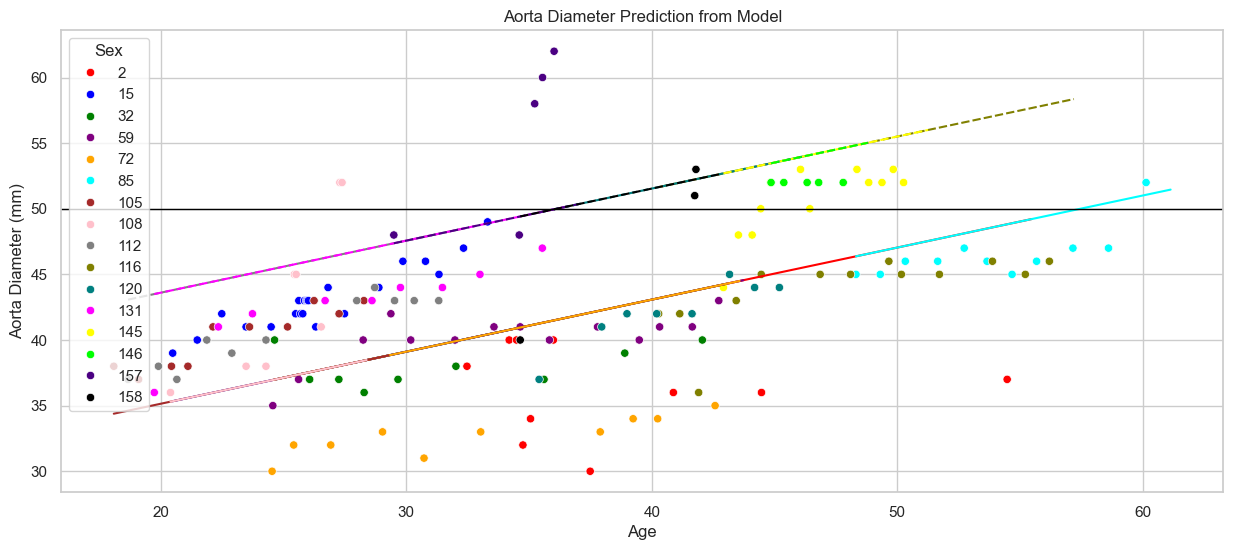

In [34]:
## Trying 
new_df1 = new_data[new_data['patnr'].isin([2, 15, 32, 59, 72, 85, 105, 108, 112, 116, 120, 131, 145, 146, 157, 158])]
plt.figure(figsize=(15, 6))

# Real diameter
sns.scatterplot(data=plot_data, x='age', y='diameter', hue='patnr',legend=True,
                markers=True, palette=patient_palette)

# Predicted values
sns.lineplot(data=new_df1, x='age', y='prediction', hue='patnr', legend=False,
             style='sexe', markers=False,palette =patient_palette)
plt.axhline(y=50, color='black', linestyle='-', linewidth=1)
plt.title('Aorta Diameter Prediction from Model')
plt.xlabel('Age')
plt.ylabel('Aorta Diameter (mm)')
plt.legend(title='Sex', loc='upper left')
plt.grid(True)
plt.show()

In [440]:
# Extracting rows which have the added measurements for prediction 
rows_with_nan = new_data[new_data.isnull().any(axis=1)] # Since these are added measurements, these don't have a diameter
rows_with_nan.head()

,age,patnr,metingnr,diameter,sexe,prediction,lower_ci,upper_ci
1036,27.13,1,8,NaN,0,37.973514,35.802168,40.144861
1037,55.48,2,11,NaN,0,49.214154,44.773817,53.654490
1038,35.41,3,10,NaN,0,41.256495,38.422459,44.090530
1039,28.08,4,4,NaN,0,38.350185,36.102805,40.597565
1040,40.87,5,18,NaN,0,43.421359,40.150332,46.692385


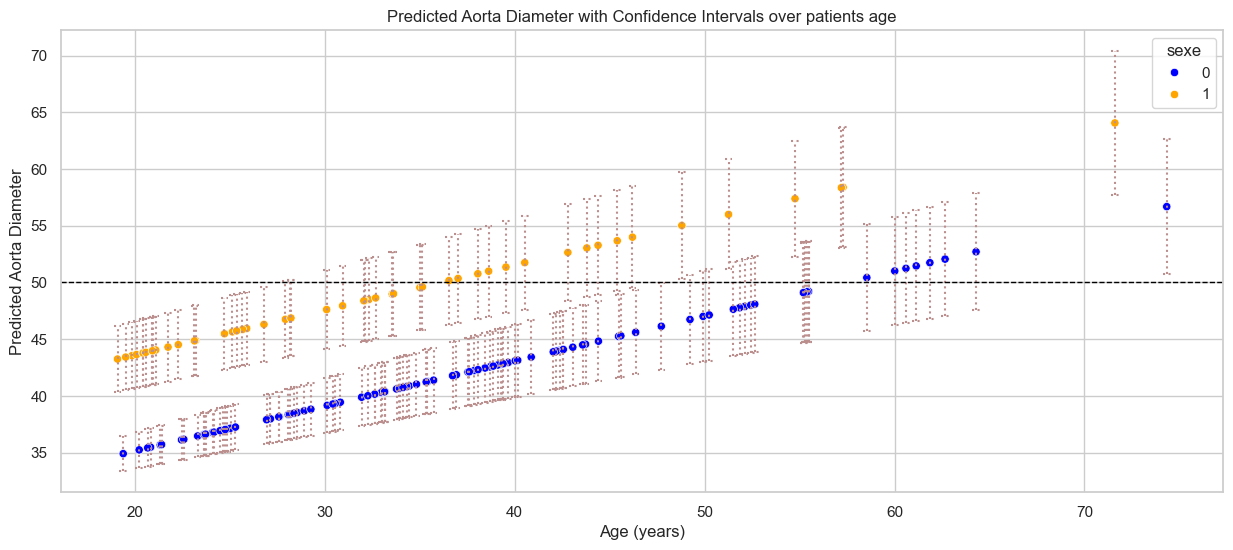

In [433]:
## Predicted with age
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the points
scatter_plot = sns.scatterplot(x='age', y='prediction', hue='sexe', data=rows_with_nan, palette={0: 'blue', 1: 'orange'}, markers=['o', '^'], ax=ax)

# Plot the prediction lines with confidence intervals
for i, row in rows_with_nan.iterrows():
    ax.plot([row['age'], row['age']], [row['lower_ci'], row['upper_ci']], color='rosybrown', linestyle='dotted')
    ax.plot([row['age'] - 0.2, row['age'] + 0.2], [row['lower_ci'], row['lower_ci']], color='rosybrown', linestyle='dotted')
    ax.plot([row['age'] - 0.2, row['age'] + 0.2], [row['upper_ci'], row['upper_ci']], color='rosybrown', linestyle='dotted')

# Set labels and title
ax.axhline(y=50, color='black', linestyle='--', linewidth=1)
ax.set_xlabel("Age (years)")
ax.set_ylabel("Predicted Aorta Diameter")
ax.set_title("Predicted Aorta Diameter with Confidence Intervals over patients age")

# Display the plot
plt.show()

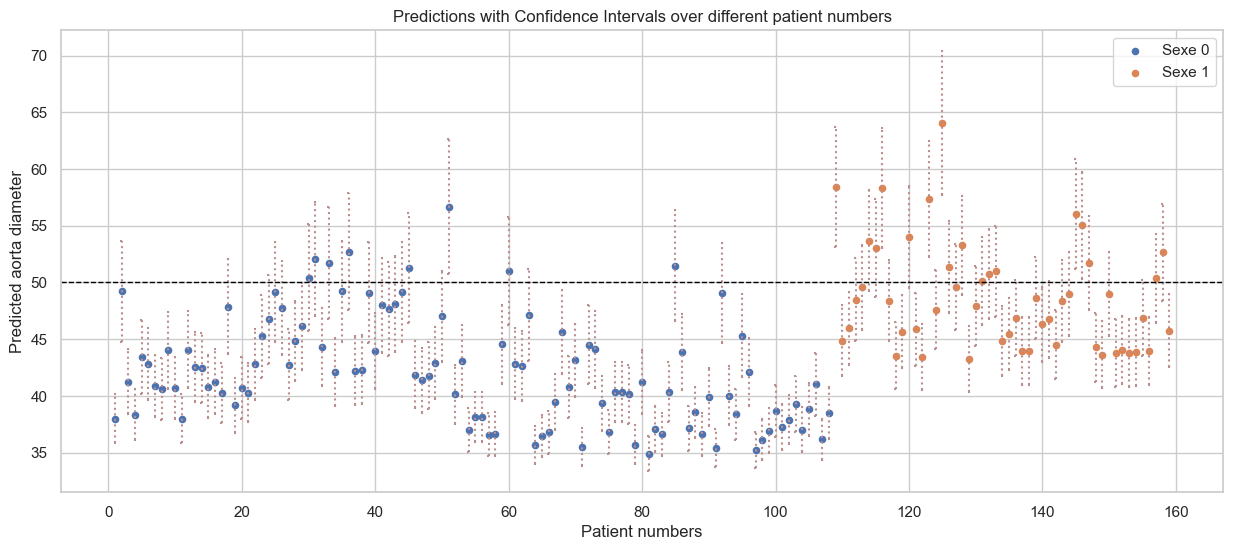

In [432]:
## Predicted with Patnr
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Iterate over sexes (0 and 1)
for sex in rows_with_nan['sexe'].unique():
    sex_data = rows_with_nan[rows_with_nan['sexe'] == sex]
    # Scatter plot for prediction
    ax.scatter(sex_data['patnr'], sex_data['prediction'], marker='o', s=20, label=f'Sexe {sex}')
    
    # Dotted lines for confidence intervals
    for idx, row in sex_data.iterrows():
        ax.plot([row['patnr'], row['patnr']], [row['lower_ci'], row['upper_ci']], color='rosybrown', linestyle='dotted')
        ax.plot([row['patnr'] - 0.2, row['patnr'] + 0.2], [row['lower_ci'], row['lower_ci']], color='rosybrown', linestyle='dotted')
        ax.plot([row['patnr'] - 0.2, row['patnr'] + 0.2], [row['upper_ci'], row['upper_ci']], color='rosybrown', linestyle='dotted')

# Set labels and title
ax.axhline(y=50, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Patient numbers')
ax.set_ylabel('Predicted aorta diameter')
ax.set_title('Predictions with Confidence Intervals over different patient numbers')

# Add legend
ax.legend()
# Show the plot
plt.show()